# Lecture 2 - K-Means

K-Means is a very popular and intuitive clustering method. It's a centroid-based method yielding partitional, exclusive and complete clusterings, i.e., each data point is assigned to exactly one cluster. It's only input parameter is the number of clusters K. In corner cases such as a very bad initialization of the centroids, one more clusters might be empty.

**Note:** This notebook contains some content covered in Lecture 3, particularly the parts of evaluating the quality of clusterings.

## Setting up the notebook

Specify how plots get rendered

In [3]:
%matplotlib notebook

Make all required imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Playing with Toy Data

[`sklearn.datasets`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) provides a series of methods to randomly generate sample data. 

Try different methods and see how the results will change.

In [5]:
X, y = make_blobs(n_samples=100, centers=5, n_features=2, cluster_std=0.85, random_state=11)
#X, y = make_moons(n_samples=250, noise=0.105, random_state=0)
#X, y = make_circles(n_samples=500, noise=0.06, factor=0.5, random_state=0)

We can plot the data to get a first idea how our data looks like. Of course, in practice this might not be (trivially) possible with data points of more then 3 dimensions. The following example, however, focus on illustrating the characteristics of K-Means.

<IPython.core.display.Javascript object>


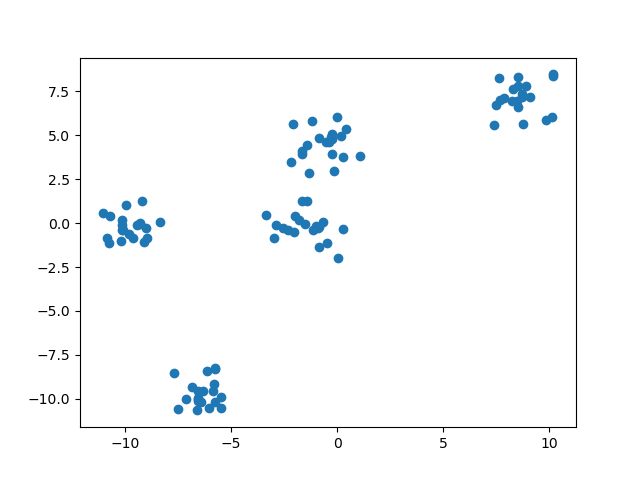

In [6]:
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.show()

The method below plots the clustering, and we will use it throughout the rest of the notebook. The input of the methods is an instance of [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) of calculating the clusters.

In [7]:
def plot_clusters(kmeans, data):
    plt.figure()
    
    # Plot all the data points a color-code them w.r.t. to their cluster label/id
    plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, s=50, cmap=plt.cm.tab10)
    
    # Plot the cluster centroids as fat plus signs
    for cluster_id, centroid in enumerate(kmeans.cluster_centers_):
        plt.scatter(centroid[0], centroid[1], marker='+', color='k', s=250, lw=5)

    plt.tight_layout()
    plt.show()

### Effects of Different Values for k (Number of Cluster)

The number of clusters k has to be specified by the user. In general, it's no obvious how to set k. The following loop calculates the K-Means clusterings with a value for k from 2 to 20. Each run (i.e., value of k will give us a different SSE and Silhouette Score).

In [8]:
sse, silhouette, ari = [], [], []

for k in range(2, 20+1):

    # Run K-Means for the current number of clusters k
    kmeans = KMeans(n_clusters=k).fit(X)
    
    # "inertia_" holds the sum of squared distances of samples to their closest cluster center
    # Record the current (k, sse) pair
    sse.append((k, kmeans.inertia_))
    
    # silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters    
    silhouette.append((k, silhouette_score(X, kmeans.labels_)))
    
    ari.append((k, adjusted_rand_score(y, kmeans.labels_)))
    
# Convert to numpy array for convenience
sse = np.array(sse)
silhouette = np.array(silhouette)    
ari = np.array(ari)

Let's plot the results -- first for SSE

<IPython.core.display.Javascript object>


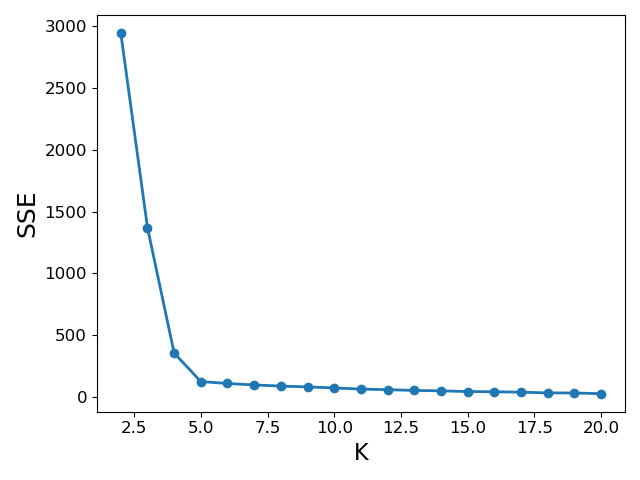

In [9]:
plt.figure()
plt.xlabel('K', fontsize=16)
plt.ylabel('SSE', fontsize=18)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.plot([s[0] for s in sse], [s[1] for s in sse], marker='o', lw=2)
plt.tight_layout()
plt.show()

Of course, the exact plot will differ depending on the type of data (blob, moons, circles), on the parameters when creating the data (e.g., the level of noise), as well as on the execution of K-Means itself -- note the K-Means is by default K-Means++, so the cluster centroids are not chosen randomly.

However, there are some general observations

* For increasing values of k, the SSE will always go down, and the SSE will always be 0 if k is larger than the number of data points. This just derives directly from the definition of SSE.

* For (reasonably) well-separated blobs, we can see clear "elbow" which indicates the best value for k. Try increasing the noise, and you should see that the elbow will become less and less pronounced.

* For non-blob data, the SEE will of course still go down with increasing values of k, but a clear elbow is typically missing

Now the plot for the silhouette scores

<IPython.core.display.Javascript object>


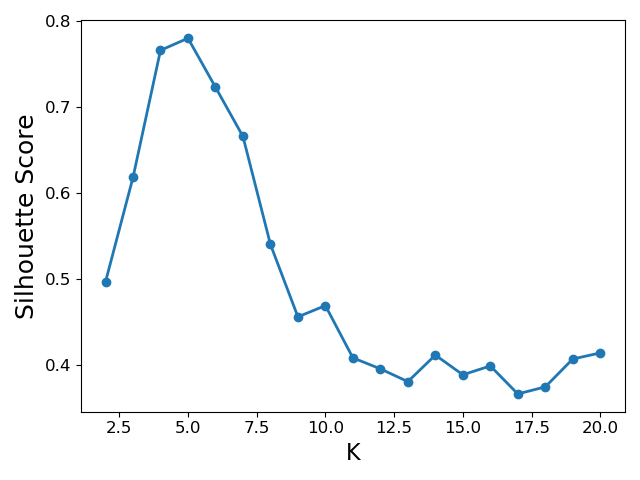

In [10]:
plt.figure()
plt.xlabel('K', fontsize=16)
plt.ylabel('Silhouette Score', fontsize=18)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.plot([s[0] for s in silhouette], [s[1] for s in silhouette], marker='o', lw=2)
plt.tight_layout()
plt.show()

Again, for well-separated blobs, the silhouette scores is highest for the expected values of k. Adding more noise to the blobs or using non-blob-like data will also again in much less obvious trends. Check it out for different data samples generated using different parameters.

Last, we can plot the ARI values

<IPython.core.display.Javascript object>


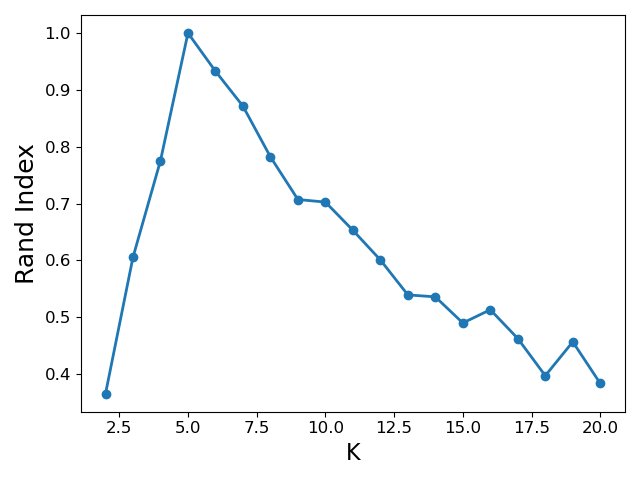

In [11]:
plt.figure()
plt.xlabel('K', fontsize=16)
plt.ylabel('Rand Index', fontsize=18)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.plot([s[0] for s in ari], [s[1] for s in ari], marker='o', lw=2)
plt.tight_layout()
plt.show()

### Plot Clusters for Different Values of k

To get a better sense how K-Means behaves, run K-Means for different generated data (with different parameters) and different values for k and plot the results

<IPython.core.display.Javascript object>


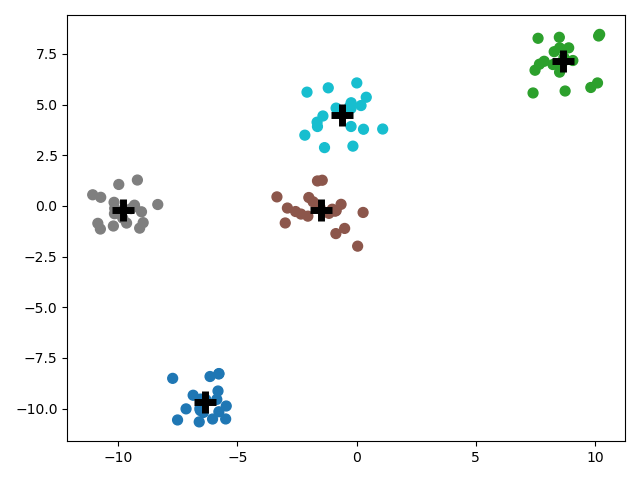

In [13]:
kmeans = KMeans(n_clusters=5).fit(X)

plot_clusters(kmeans, X)

### K-Means with Random Initialization of Centroids

As mentiond above, [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) uses the K-means++ approach to initialize the centroids. By default, K-Means runs 10 times and picks the best results (check the `n_init` parameter).

We can make the algorithm manually "stupid" by setting `init='random'` and `n_init=1`. Note that `random` in this implementation means a random selection of data points -- and not an arbitrary point between data points. As such, the will never be any empty cluster, but potentially clusters with only one data point (the one that got chosen as initial centroid)

With this setting, let's run K-Means 100 times and record the worst results in terms of the largest SSE. You can run this method and plot several times and see the different results.

In [14]:
worst_sse, worst_kmeans = 0, None

for _ in range(0, 100):

    # Run K-Means (k=5 here assumes the default sample data with 5 blobs; change as needed)
    kmeans = KMeans(n_clusters=10, init='random', n_init=1).fit(X)
    
    # Keep track of the worst run of K-Means over the dataset (worst = largest SSE)
    if kmeans.inertia_ > worst_sse:
        worst_sse = kmeans.inertia_
        worst_kmeans = kmeans

...and we can of course plot the clusters again

<IPython.core.display.Javascript object>


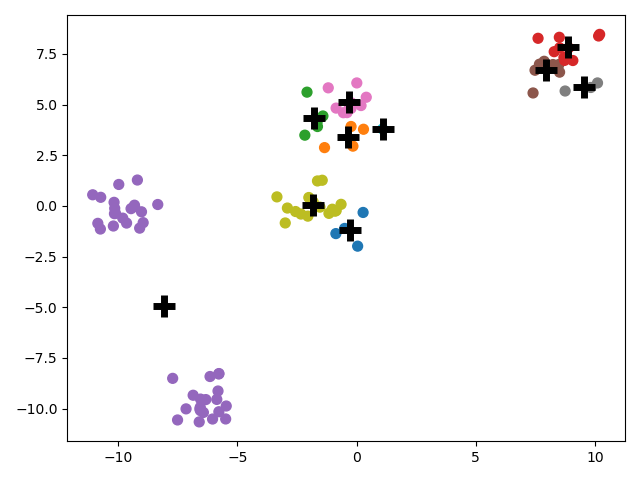

In [16]:
plot_clusters(worst_kmeans, X)

Clearly, K-Means can suffer from bad/unfortunate initialization of the centroids. That's why all practical implementation use a method to (almost) guarantee a good initialization.

## K-Means over a Real-World Dataset

We first use a publicly available dataset for diabetes prediction: https://www.kaggle.com/uciml/pima-indians-diabetes-database

This is convenient dataset since all attributes for the clustering are numerical, an we can use the default Euclidean distance as similarity measure

In [17]:
df = pd.read_csv('data/diabetes.csv')

df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Note:** Remember, in practice, you should always do at least a basic EDA to check for missing values and (obvious) outliers! We skip this step to keep the notebook simple.

First, we need to create the input data X for the clustering and -- for this example -- the label data y

In [18]:
X = df.drop(columns=['Outcome']).to_numpy()
y = df['Outcome'].to_numpy()

Optionally, we can scale the data. Try with and without scaling and compare the results

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Estimate Parameter Settings

Similar to the toy data above, we can evaluate the effects of varying K on the clusterings.

In [22]:
sse, silhouette, ari = [], [], []

for k in range(2, 20+1):

    # Run K-Means for the current number of clusters k
    kmeans = KMeans(n_clusters=k).fit(X)
    
    # "inertia_" holds the sum of squared distances of samples to their closest cluster center
    # Record the current (k, sse) pair
    sse.append((k, kmeans.inertia_))
    
    # silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters    
    silhouette.append((k, silhouette_score(X, kmeans.labels_)))
    
    ari.append((k, adjusted_rand_score(y, kmeans.labels_)))
    
# Convert to numpy array for convenience
sse = np.array(sse)
silhouette = np.array(silhouette)    
ari = np.array(ari)

And again, we can plot and inspect the results

<IPython.core.display.Javascript object>


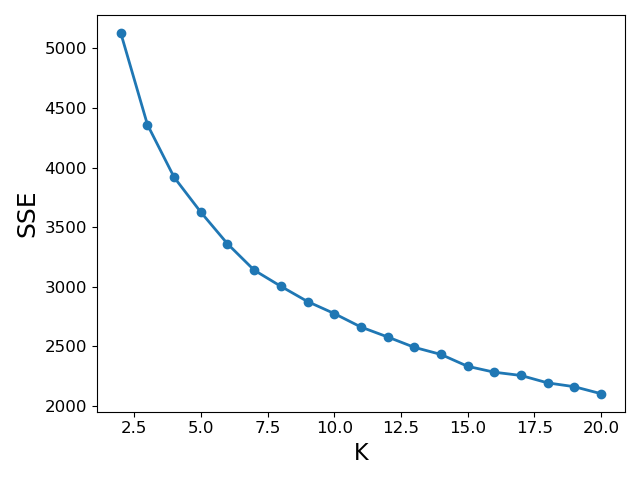

In [23]:
plt.figure()
plt.xlabel('K', fontsize=16)
plt.ylabel('SSE', fontsize=18)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.plot([s[0] for s in sse], [s[1] for s in sse], marker='o', lw=2)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


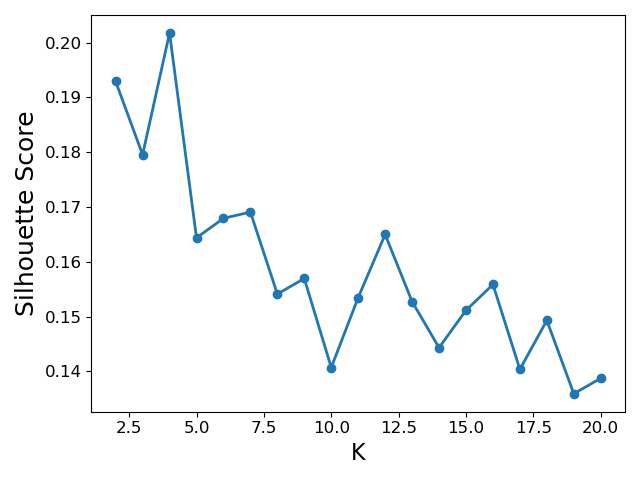

In [24]:
plt.figure()
plt.xlabel('K', fontsize=16)
plt.ylabel('Silhouette Score', fontsize=18)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.plot([s[0] for s in silhouette], [s[1] for s in silhouette], marker='o', lw=2)
plt.tight_layout()
plt.show()

To find the index of the highest silhouette score, we can use the handy [`numpy.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) method. With the index, we then can find the corresponding value for k that resulted in the score

In [25]:
best_run = np.argmax(silhouette[:,1])
best_k = int(silhouette[:,0][best_run])

print(best_k)

4


In [26]:
best_kmeans = KMeans(n_clusters=best_k).fit(X)

<IPython.core.display.Javascript object>


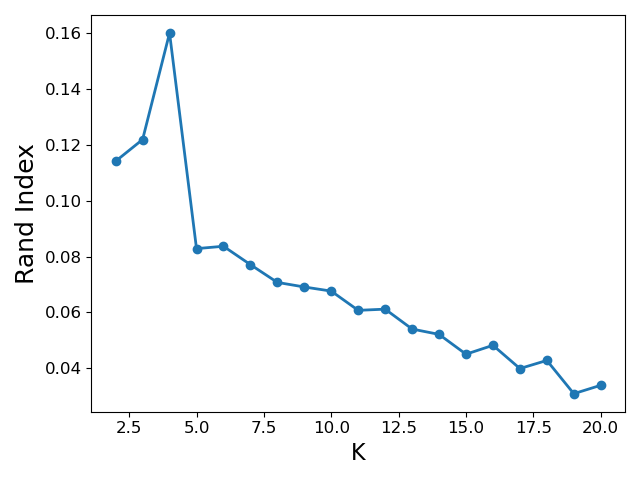

In [27]:
plt.figure()
plt.xlabel('K', fontsize=16)
plt.ylabel('Rand Index', fontsize=18)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
plt.plot([s[0] for s in ari], [s[1] for s in ari], marker='o', lw=2)
plt.tight_layout()
plt.show()

### Visualization

As our dataset now has more than 3 attributes, we cannot direct plot the clusters. However, we can use dimensionality reduction techniques to map the data points into a lower-dimensional space. In this example, we use PCA to map our data into 2d -- a detailed discussion about PCA is beyond the scope of this notebook.

In [28]:
X_pca = PCA(n_components=2).fit_transform(X)

<IPython.core.display.Javascript object>


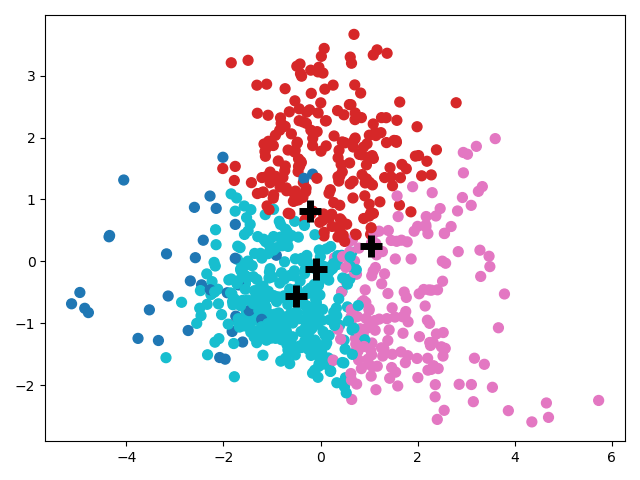

In [32]:
plot_clusters(best_kmeans, X_pca)

Independent from the different result or PCA and t-SNE, the clusters do no really look as expected. The issue is that dimensionality reduction always result in the loss of information.